In [24]:
import torch
import torchaudio
import audioldm2.utilities.audio as Audio
import matplotlib.pyplot as plt
from audioldm2.latent_diffusion.modules.audiomae.AudioMAE import Vanilla_AudioMAE, AudioMAE
from audioldm2.utils import default_audioldm_config, download_checkpoint
from audioldm2.latent_diffusion.models.ddpm import LatentDiffusion
import audioldm2.utilities.audio as Audio
%matplotlib inline
import soundfile as sf
import os
import numpy as np

In [3]:
# extracting checkpoint for audioMAE
checkpoint = torch.load('/root/.cache/huggingface/hub/models--haoheliu--audioldm2-full/snapshots/a1c61356b3b9ecfa534daf5d784a901af463d470/audioldm2-full.pth')
audiomae_ckpt = {}
for i in checkpoint['state_dict'].keys():
    if 'cond_stage_models.0.cond_stage_models.2.audiomae.model.' in i:
        # keep the last three strings after dot
        mae_i = '.'.join(i.split('.')[5:])
        audiomae_ckpt[mae_i] = checkpoint['state_dict'][i]


In [20]:
def wav_feature_extraction(waveform):
    waveform = waveform[0, ...]
    waveform = torch.FloatTensor(waveform)

    log_mel_spec, stft, energy = Audio.tools.get_mel_from_wav(waveform, self.STFT)

    log_mel_spec = torch.FloatTensor(log_mel_spec.T)
    stft = torch.FloatTensor(stft.T)

    log_mel_spec, stft = self.pad_spec(log_mel_spec), self.pad_spec(stft)
    return log_mel_spec, stft


def get_mel_from_wav(audio, _stft):
    audio = torch.clip(torch.FloatTensor(audio).unsqueeze(0), -1, 1)
    audio = torch.autograd.Variable(audio, requires_grad=False)
    melspec, magnitudes, phases, energy = _stft.mel_spectrogram(audio)
    melspec = torch.squeeze(melspec, 0).numpy().astype(np.float32)
    magnitudes = torch.squeeze(magnitudes, 0).numpy().astype(np.float32)
    energy = torch.squeeze(energy, 0).numpy().astype(np.float32)
    return melspec, magnitudes, energy

def mel_spectrogram_to_waveform(self,
        mel, savepath=".", bs=None, name="outwav", save=True
    ):
        # Mel: [bs, 1, t-steps, fbins]
        if len(mel.size()) == 4:
            mel = mel.squeeze(1)
        mel = mel.permute(0, 2, 1)
        waveform = self.first_stage_model.vocoder(mel)
        waveform = waveform.cpu().detach().numpy()
        if save:
            save_waveform(self, waveform, savepath, name)
        return waveform

def save_waveform(self, waveform, savepath, name="outwav"):
    for i in range(waveform.shape[0]):
        path = os.path.join(
            savepath,
            "%s.wav"
            % (
                os.path.basename(name[i])
                if (not ".wav" in name[i])
                else os.path.basename(name[i]).split(".")[0]
            ),
        )
        
        todo_waveform = waveform[i, 0]
        todo_waveform = (
            todo_waveform / np.max(np.abs(todo_waveform))
        ) * 0.8  # Normalize the energy of the generation output
        sf.write(path, todo_waveform, samplerate=self.sampling_rate)

In [5]:
config = default_audioldm_config(model_name="audioldm2-full")

In [6]:
stft_config = Audio.stft.TacotronSTFT(
            config["preprocessing"]["stft"]["filter_length"],
            config["preprocessing"]["stft"]["hop_length"],
            config["preprocessing"]["stft"]["win_length"],
            config["preprocessing"]["mel"]["n_mel_channels"],
            config["preprocessing"]["audio"]["sampling_rate"],
            config["preprocessing"]["mel"]["mel_fmin"],
            config["preprocessing"]["mel"]["mel_fmax"],
        )

/workspace/data/raven/AudioLDM2/audioldm2/utilities/audio/stft.py:42: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/workspace/data/raven/AudioLDM2/audioldm2/utilities/audio/stft.py:145: FutureWarning: Pass sr=16000, n_fft=1024, n_mels=64, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


In [7]:
latent_diffusion = LatentDiffusion(**config["model"]["params"])

/root/miniconda3/envs/audioldm/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/root/miniconda3/envs/audioldm/lib/python3.8/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/root/miniconda3/envs/audioldm/lib/python3.8/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


DiffusionWrapper has 346.94 M params.


/root/miniconda3/envs/audioldm/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [8]:
latent_diffusion.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [9]:
# real audio
waveform, sr = torchaudio.load('mix_16k.wav')
waveform = waveform[:,:163872][0] # remove batch dim

In [40]:
stft_config.mel_spectrogram

<bound method TacotronSTFT.mel_spectrogram of TacotronSTFT(
  (stft_fn): STFT()
)>

In [10]:
log_mel_spec, stft, energy = Audio.tools.get_mel_from_wav(waveform, stft_config)

In [11]:
log_mel_spec = torch.FloatTensor(log_mel_spec)

In [12]:
# input is supposed to have [1, 1, 1024, 64] in the original code
input = log_mel_spec.T.unsqueeze(0).unsqueeze(0)
encoder_posterior = latent_diffusion.encode_first_stage(input)


In [13]:
z = latent_diffusion.get_first_stage_encoding(encoder_posterior).detach()

In [36]:
z.shape

torch.Size([1, 8, 256, 16])

In [37]:
mel = latent_diffusion.decode_first_stage(z)

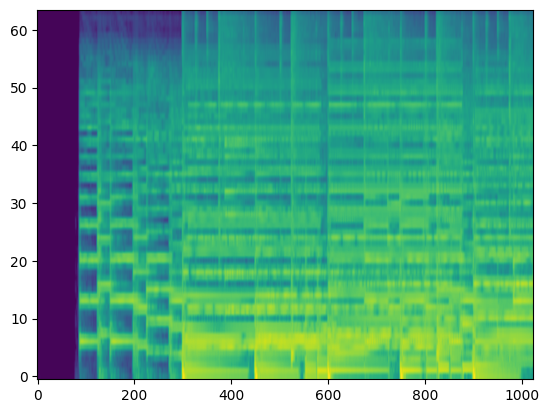

In [33]:
plt.imshow(mel[0,0].T, aspect='auto', origin='lower')

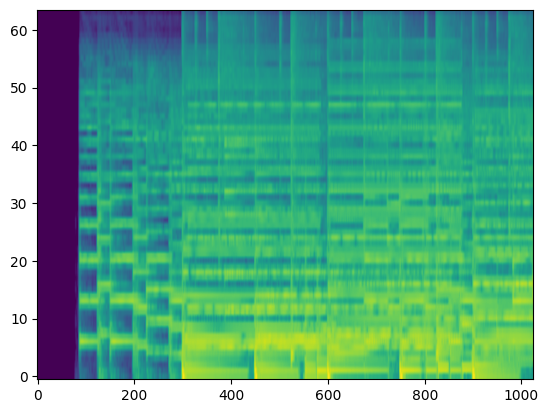

In [34]:
plt.imshow(log_mel_spec, aspect='auto', origin='lower')

In [38]:
mel_spectrogram_to_waveform(latent_diffusion, mel)

array([[[0.00018603, 0.00017419, 0.00016541, ..., 0.04695877,
         0.05636167, 0.05747487]]], dtype=float32)

In [39]:
torchaudio.save('i.wav', waveform.unsqueeze(0), 16000)